

---


# P7 - Implémentez un modèle de scoring

---
La société financière  "Prêt à dépenser"propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt. 
L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé.
**Missions**
- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
- Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
- Mettre en production le modèle de scoring de prédiction à l’aide d’une API, ainsi que le dashboard interactif qui appelle l’API pour les prédictions.


Dans le présent Notebook , je présente la partie modélisation dezs données préparées dans la partie analyse exploratoire.


---


## Installation des bibliothèques

---

In [ ]:
pip install catboost

In [ ]:
pip install lightgbm

In [ ]:
pip install shap

In [ ]:
!pip install --upgrade scikit-learn --user



---


## Imporatation de bibliothèques

---

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive',force_remount=True)


Mounted at /content/gdrive


In [ ]:
import pandas as pd
import seaborn as sns
import time, pickle

from zipfile import ZipFile

#Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")


In [ ]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [ ]:
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':15,
     'ytick.labelsize':15,
     'axes.labelsize': 15,
     'legend.fontsize': 15,
     'axes.titlesize':15,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })



---


## Les fonctions

---

In [ ]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):
    '''This function will make a pretty plot of 
    an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))

    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='red', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    if feature_importances : 
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]
    
        features = []
        for i in range(20):
            features.append(data_train.columns[indices[i]]) #After RFECV selection > X_data created

        sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("red"))
        plt.xlabel('Features importance')
        plt.xticks(rotation=90)

    plt.show()


In [ ]:
def train_models(model, X_train_selected, X_test_selected, y_train, y_test):

    models = [
          #Ensemble methods
          CatBoostClassifier(),
          RandomForestClassifier(n_estimators=100),
          DummyClassifier(),
          LGBMClassifier()
          ]

    model.fit(X_train_selected, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test_selected)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test_selected)),
      'Precision': precision_score(y_test, model.predict(X_test_selected)),
      'Recall': recall_score(y_test, model.predict(X_test_selected)),
      'F1': f1_score(y_test, model.predict(X_test_selected))
      }
          
    return output


In [ ]:
def gain_seuil(model, y_set, x_set):
    
    """
    Evolution du gain en fonction du seuil de solvabilité fixé
    Si score < seuil : client solvable
    Sinon : client non solvable
    
    """
    cost_function = []
    threshold_x = np.linspace(0.0, 1, 30)
    
    for threshold in threshold_x:
        
        # Score du modèle : 0 à 1
        y_scores = model.predict_proba(x_set)[:, 1]
        
        # Score > seuil de solvabilité : retourne 1 sinon 0
        y_pred = (y_scores > threshold)
        
        y_pred = np.array(y_pred > 0) * 1
        # Calcul de l'indice bancaire
        cost_function.append(custom_metric(y_set, y_pred))
        
    # Affichage du gain en fonction du seuil de solvabilité    
    plt.plot(threshold_x, cost_function)
    plt.xlabel("Seuil de probabilité")
    plt.ylabel("Indice banquaire")
    plt.xticks(np.linspace(0.1, 1, 10))

In [ ]:
def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': f1_score(y_test, model.predict(X_test))
      }
          
    return output


In [ ]:
def custom_metric(y_true, y_pred, fn_value=-0.7, fp_value=-0.2, vp_value=0, vn_value=0.2):

    '''
    Métrique métier pour minimiser le risque d'accord prêt pour la
    banque en pénalisant les faux négatifs ( grande perte ).
    '''

    
    #Matrice de Confusion
    mat_conf = confusion_matrix(y_true, y_pred)
    
    # Nombre de vrai Négatifs
    vn = mat_conf[0, 0]
    # Nombre de Faux Négatifs
    fn = mat_conf[1, 0]
    # Nombre de Faux Positifs
    fp = mat_conf[0, 1]
    # Nombre de vrai Positifs
    vp = mat_conf[1, 1]
    
    # Gain total
    Gain = vp*vp_value + vn*vn_value + fp*fp_value + fn*fn_value
    
    # Gain maximum
    max_Gain = (fp + vn)*vn_value + (fn + vp)*vp_value
    
    # Gain minimum
    min_Gain = (fp + vn)*fp_value + (fn + vp)*fn_value
    
    # Gain normalisé entre 0 et 1
    Gain_normalized = (Gain - min_Gain)/(max_Gain - min_Gain)
    
    return Gain_normalized  # Retourne la fonction d'évaluation

In [ ]:
import time
def plot_roc_curve(classifiers, X, y, n_splits=5):
# Création du DataFrame initial
    df = pd.DataFrame(columns=['Modèle','AUC','STD','Temps'])

    kf = KFold(n_splits=n_splits)    
    #df_score=pd.DataFrame()
    models=[]
    times=[]
    for name_clf, clf in classifiers.items():
        print(name_clf)
        model2save= name_clf
        tprs = []
        aucs = []

        mean_fpr = np.linspace(0, 1, 100)
        t0 = time.time()

        for i, (train, test) in enumerate(kf.split(X, y)):
            clf.fit(X.iloc[train, :], y.iloc[train])
            y_pred_grd = clf.predict_proba(X.iloc[test, :])[:, 1]
            fpr, tpr, thresholds = roc_curve(y.iloc[test], y_pred_grd)

            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            thresholds = auc(fpr, tpr)

            aucs.append(thresholds)
        times2save=np.round((time.time()-t0),2)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        df2save = pd.DataFrame([[model2save,np.round(mean_auc,2),np.round(std_auc,2),times2save]],columns=['Modèle','AUC','STD','Temps'])
        df = df.append(df2save, ignore_index=True)

        plt.plot(mean_fpr, mean_tpr,
            label=name_clf + r'(AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2,
            alpha=.8)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    #df_score = pd.DataFrame(list(zip(models, mean_auc,times)),columns =['Modele', 'AUC','Temps'])
    
    #df_score =pd.DataFrame({'Modèle': models,'AUC':mean_auc,'std_AUC':std_auc,'Temps':times}).sort_values('AUC', ascending=False)

    display(df)


---


## Exploration des données

---

In [ ]:
z = ZipFile("/content/gdrive/My Drive/derniercsv/data_train.zip")
data_train = pd.read_csv(z.open('data_train.csv'), index_col='SK_ID_CURR', encoding ='utf-8')
#data_train.drop('SK_ID_CURR', axis=1, inplace=True)
data_train.shape


(307507, 308)

In [ ]:
TARGET = pd.read_csv('/content/gdrive/My Drive/derniercsv/TARGET.csv', index_col='SK_ID_CURR')
TARGET.shape


(307507, 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_train.values, TARGET.values, test_size=0.3, random_state=42)


In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((215254, 308), (92253, 308), (215254, 1), (92253, 1))

# Partie modelisation
Ce projet vise à mieux comprendre le défaut de crédit rencontré chez certains clients, ainsi qu'à prédire leur acceptation ou leur refus de crédit, représentés par une sortie binaire. Nous allons dans cette partie rechercher le meilleur modèle qui répondera à nos besoins 





## Regression Logistique (Baseline)
Pour obtenir une première estimation des performances potentielles,j'utilise la régression logistique comme modèle de référence. Je comapre par la suite les résulats obtenus avec d'autres modèles afin de choisir le meilleur.


### Premier test de la régression logistique :

In [ ]:
%%time
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))


AUC : 0.6954
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84811
         1.0       0.00      0.00      0.00      7442

    accuracy                           0.92     92253
   macro avg       0.46      0.50      0.48     92253
weighted avg       0.85      0.92      0.88     92253

CPU times: user 5.53 s, sys: 695 ms, total: 6.23 s
Wall time: 4.89 s


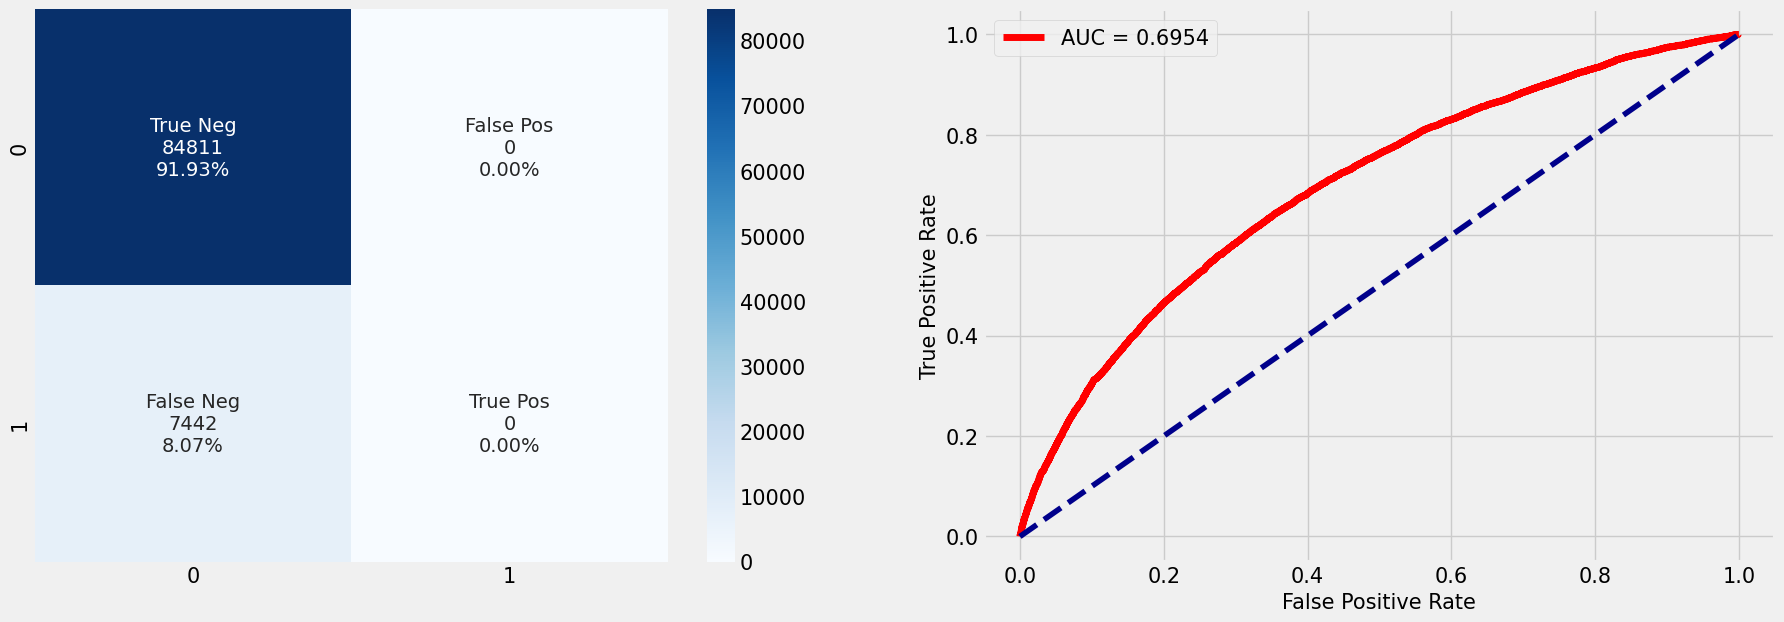

In [ ]:
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], feature_importances=None)


####Bilan 

---


Comme je l'ai expliqué dans le notebook d'anlayse exploratoire , le déséquilibre des classes est très prononcé dans l'échantillon de travail, avec 92% des individus classés en modalité 0 et seulement 8% en modalité 1, qui représente le défaut de paiement de crédit.
Un fort désiquilibre de la précision entre la Target 0 (0.92) et la Target 1 (0).
Afin de remédier à ce déséquilibre, je vais utiliser plusieurs technique de rééuilibrage de données pour ajuster la distribution des classes et obtenir une répartition plus équilibrée.



## L'équilibrage de classes :


---


C'est une étape importante dans l'apprentissage automatique lorsqu'on travaille avec des problèmes de classification binaire et que les classes sont déséquilibrées, c'est-à-dire lorsque l'une des classes est beaucoup plus fréquente que l'autre. Il existe plusieurs techniques couramment utilisées pour équilibrer les classes. Je m'interesse particulièrement aux trois techniques suivantes:
- **SMOTE (Synthetic Minority Over-sampling Technique) :** 
une technique populaire d'équilibrage de classes qui vise à résoudre le problème des classes déséquilibrées en augmentant la taille de la classe minoritaire en générant des exemples synthétiques. 
- **UnderSampling (sous-échantillonnage)** est une autre technique d'équilibrage de classes qui vise à réduire la taille de la classe majoritaire en supprimant ou en échantillonnant aléatoirement des exemples de cette classe. L'objectif de l'undersampling est de créer un nouvel ensemble de données équilibré en réduisant la taille de la classe majoritaire pour correspondre à la taille de la classe minoritaire.
- **Class weight (poids de classe)** est une technique qui attribue des poids différents aux différentes classes lors de l'apprentissage d'un modèle d'apprentissage automatique. L'idée derrière les poids de classe est de donner plus d'importance à la classe minoritaire en attribuant des poids plus élevés à cette classe. Cela permet au modèle d'accorder plus d'attention aux échantillons de la classe minoritaire lors de l'estimation des paramètres.




### 1-Régression logistique avec SMOTE



In [ ]:
print("Label 1, avant l'utilisation de  SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, avant l'utilisation de  SMOTE: {} ".format(sum(y_train==0)))


Label 1, avant l'utilisation de  SMOTE: 17383 
Label 0, avant l'utilisation de  SMOTE: 197871 


In [ ]:
%%time
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


CPU times: user 14.5 s, sys: 994 ms, total: 15.5 s
Wall time: 9.07 s


In [ ]:
print("Label 1, après l'utilisation de SMOTE: {}".format(sum(y_train_res==1)))
print("Label 0, après l'utilisation de SMOTE: {}".format(sum(y_train_res==0)))


Label 1, après l'utilisation de SMOTE: 197871
Label 0, après l'utilisation de SMOTE: 197871


In [ ]:
%%time
lrsm = LogisticRegression(C = 0.0001, max_iter=100)
lrsm.fit(X_train_res, y_train_res)
roc_auc = roc_auc_score(y_test, lrsm.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lrsm.predict(X_test)))


AUC : 0.7192
              precision    recall  f1-score   support

         0.0       0.96      0.68      0.79     84811
         1.0       0.15      0.64      0.24      7442

    accuracy                           0.67     92253
   macro avg       0.55      0.66      0.52     92253
weighted avg       0.89      0.67      0.75     92253

CPU times: user 16.7 s, sys: 1.47 s, total: 18.2 s
Wall time: 10.8 s


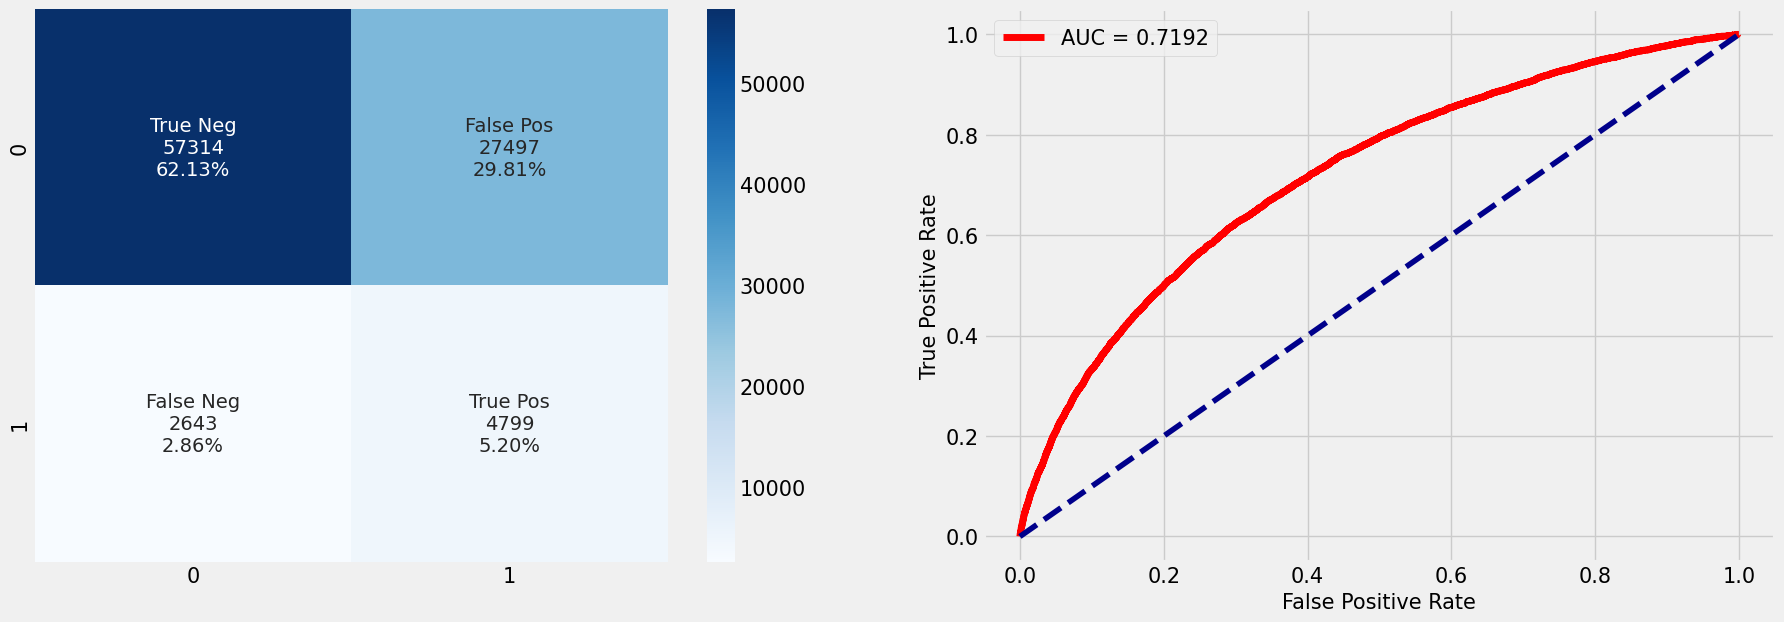

In [ ]:
cf_matrix_roc_auc(lr, y_test, lrsm.predict(X_test), lrsm.predict_proba(X_test)[:,1], feature_importances=None)


Bilan

---

Almélioration de L'AUC avec SMOE (0.7192)

### 2-Régression logistique avec Class weight 


In [ ]:
print("Label 1, après l'utilisation de class weight: {} ".format(sum(y_train==1)))
print("Label 0, après  l'utilisation de  class weight: {} ".format(sum(y_train==0)))


Label 1, après l'utilisation de class weight: 17383 
Label 0, après  l'utilisation de  class weight: 197871 


In [ ]:
%%time
class_weights = {0: 1.0, 1: 5.0}  # Exemple de poids de classe déséquilibrés
lrcw = LogisticRegression(C = 0.0001, max_iter=100,class_weight=class_weights)
lrcw.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, lrcw.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lrcw.predict(X_test)))


AUC : 0.7218
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     84811
         1.0       0.35      0.05      0.09      7442

    accuracy                           0.92     92253
   macro avg       0.64      0.52      0.53     92253
weighted avg       0.88      0.92      0.89     92253

CPU times: user 11.9 s, sys: 1.36 s, total: 13.2 s
Wall time: 9.11 s


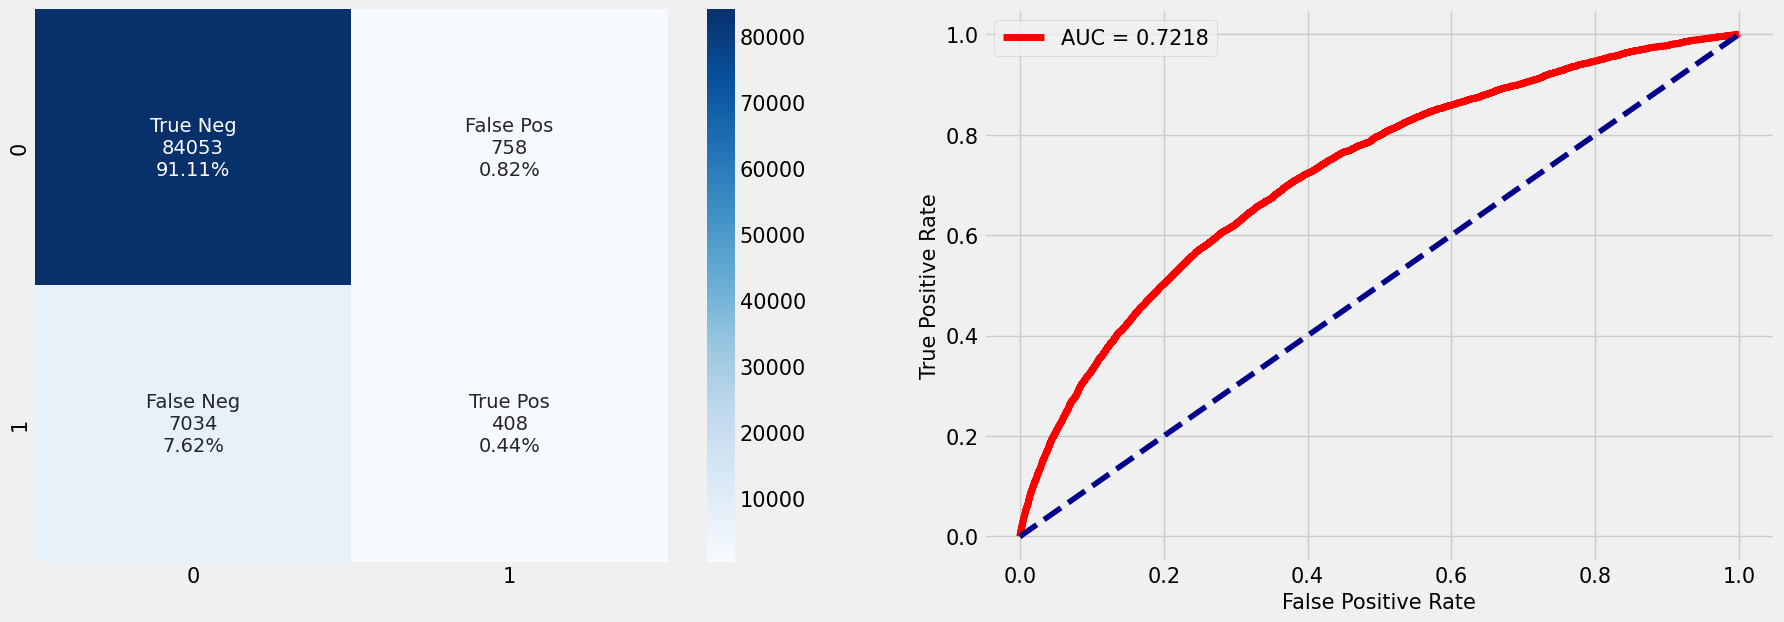

In [ ]:
cf_matrix_roc_auc(lrcw, y_test, lrcw.predict(X_test), lrcw.predict_proba(X_test)[:,1], feature_importances=None)


### 3-Régression logistique avec UnderSampling


In [ ]:
print("Label 1, avant l'utilisation de UnderSampling: {} ".format(sum(y_train==1)))
print("Label 0, avant l'utilisation de UnderSampling: {} ".format(sum(y_train==0)))

Label 1, avant l'utilisation de UnderSampling: 17383 
Label 0, avant l'utilisation de UnderSampling: 197871 


In [ ]:
from imblearn.under_sampling import RandomUnderSampler


In [ ]:

%%time
#pour indiquer que vous souhaitez sous-échantillonner la classe majoritaire (0)
us = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_train_us, y_train_us = us.fit_resample(X_train, y_train)

CPU times: user 84.1 ms, sys: 4.01 ms, total: 88.1 ms
Wall time: 89.2 ms


In [ ]:
print("Label 1, après l'utilisation de UnderSampling: {} ".format(sum(y_train_us==1)))
print("Label 0, après l'utilisation de UnderSampling: {} ".format(sum(y_train_us==0)))

Label 1, après l'utilisation de UnderSampling: 17383 
Label 0, après l'utilisation de UnderSampling: 17383 


In [ ]:
%%time
lrus = LogisticRegression(C = 0.0001, max_iter=100)
lrus.fit(X_train_us, y_train_us)
roc_auc = roc_auc_score(y_test, lrus.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lrus.predict(X_test)))


AUC : 0.6850
              precision    recall  f1-score   support

         0.0       0.95      0.61      0.74     84811
         1.0       0.13      0.66      0.22      7442

    accuracy                           0.61     92253
   macro avg       0.54      0.63      0.48     92253
weighted avg       0.89      0.61      0.70     92253

CPU times: user 1.08 s, sys: 267 ms, total: 1.35 s
Wall time: 820 ms


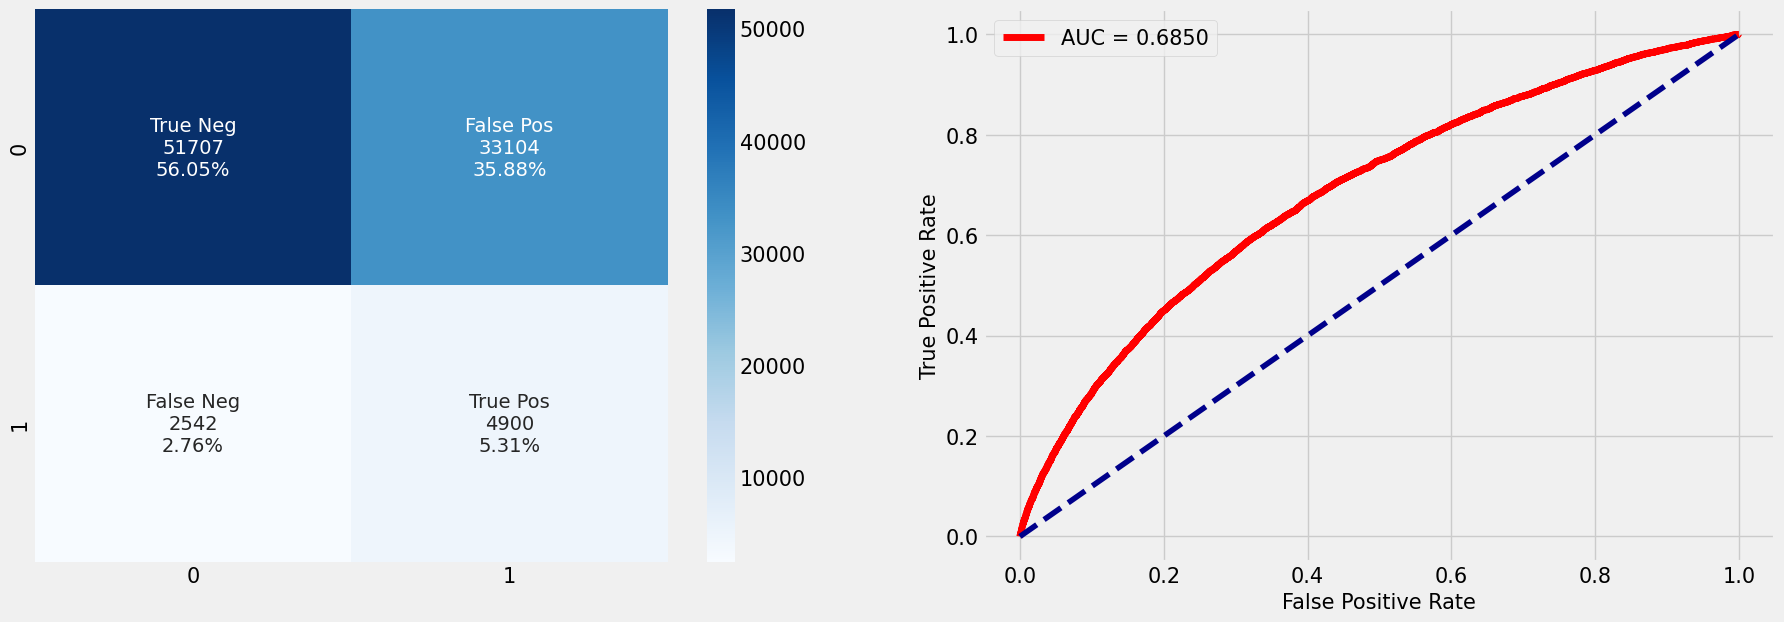

In [ ]:
cf_matrix_roc_auc(lrus, y_test, lrus.predict(X_test), lrus.predict_proba(X_test)[:,1], feature_importances=None)


### Bilan : 

---
Le meilleur AUC est assuré avec la technoique de Class Weight , suivi de SMOTE et UnderSampling en dernier.
L'utilisation de Class Weight présente  certains inconvénients:


- Sensibilité aux erreurs d'estimation des poids : Les poids de classe sont généralement déterminés en inversant la fréquence des classes dans l'ensemble de données. Cependant, si l'estimation de la fréquence est incorrecte ou biaisée, les poids de classe peuvent être mal ajustés. Cela peut conduire à une performance médiocre du modèle.

- Non adapté aux problèmes de déséquilibre extrême (Notre cas)  : Dans les cas de déséquilibre extrême des classes, où la classe minoritaire est extrêmement sous-représentée, l'utilisation des poids de classe peut ne pas suffire à compenser le manque d'exemples d'entraînement. Dans de tels cas, des techniques plus avancées comme le sur-échantillonnage ou le sous-échantillonnage peuvent être nécessaires.



Je considère donc que  SMOTE est la meilleure technique pour notre baseline , je vais refaire la meme choses avec les autres modèles et choisir la technique la plus adaptée au meilleur modèle .

Pour gérer le déséquilibre de classes dans notre jeu de données avec les autres modèles, j'ai choisi d'appliquer à la fois l'undersampling (sous-échantillonnage) et l'oversampling (suréchantillonnage). 
 J'ai décidé de ne pas utiliser la méthode (class weight) car je la considère inadaptée à notre jeu de données.



## Sélection du modèle optimal :
Dans ma démarche, je vais évaluer plusieurs modèles de classification, notamment le CatBoostClassifier, le RandomForestClassifier, le DummyClassifier et le LGBMClassifier, de la même manière que j'ai utilisé pour la Baseline. Mon objectif est de sélectionner le meilleur modèle en fonction de deux critères : le temps d'exécution et le score AUC.
Sur la base des résultats obtenus, je comparerai les performances des modèles en termes de temps d'exécution et de score AUC. Je rechercherai le modèle qui présente à la fois un temps d'exécution plus court et un score AUC plus élevé tout en assurant l'équilibrage de classes.


### 1- Sans utilisation des technique de rééquilibrage

In [ ]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []
models = [
          CatBoostClassifier(),
          RandomForestClassifier(n_estimators=100),
          DummyClassifier(),
          LGBMClassifier()]

for model in models:
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models.sort_values('AUC', ascending=False, inplace=True)


Learning rate set to 0.102118
0:	learn: 0.5966835	total: 188ms	remaining: 3m 7s
1:	learn: 0.5170168	total: 372ms	remaining: 3m 5s
2:	learn: 0.4580824	total: 537ms	remaining: 2m 58s
3:	learn: 0.4148705	total: 727ms	remaining: 3m 1s
4:	learn: 0.3792377	total: 902ms	remaining: 2m 59s
5:	learn: 0.3519166	total: 1.07s	remaining: 2m 56s
6:	learn: 0.3326992	total: 1.23s	remaining: 2m 54s
7:	learn: 0.3161331	total: 1.41s	remaining: 2m 54s
8:	learn: 0.3031825	total: 1.57s	remaining: 2m 53s
9:	learn: 0.2931207	total: 1.79s	remaining: 2m 57s
10:	learn: 0.2857333	total: 1.97s	remaining: 2m 57s
11:	learn: 0.2799989	total: 2.13s	remaining: 2m 55s
12:	learn: 0.2746885	total: 2.29s	remaining: 2m 53s
13:	learn: 0.2705396	total: 2.45s	remaining: 2m 52s
14:	learn: 0.2674502	total: 2.61s	remaining: 2m 51s
15:	learn: 0.2650421	total: 2.77s	remaining: 2m 50s
16:	learn: 0.2625578	total: 2.96s	remaining: 2m 51s
17:	learn: 0.2603907	total: 3.12s	remaining: 2m 50s
18:	learn: 0.2588766	total: 3.34s	remaining: 2m

In [ ]:
base_models.style.hide_index()

Model,AUC,Accuracy,Precision,Recall,F1,Time
CatBoostClassifier,0.776538,0.919623,0.523979,0.039640,0.073704,265.793112
LGBMClassifier,0.772211,0.919862,0.566757,0.027949,0.053272,28.151590
RandomForestClassifier,0.718212,0.919417,0.833333,0.001344,0.002683,268.910649
DummyClassifier,0.500000,0.919331,0.000000,0.000000,0.000000,0.191897


#### Bilan

---

DummyClassifier n'a pas pu obtenir de bons résultats en raison de sa simplicité et de son manque de capacité à apprendre des motifs complexes dans les données. Les autres modèles plus sophistiqués ont permis d'obtenir de meilleures performances.

Les résultats obtenus ne sont pas très significatifs car le jeu de données n'a pas encore été équilibré. L'objectif de cette démonstration était simplement de mettre en évidence la puissance des modèles ensemblistes et des arbres de décision par rapport au DummyClassifier.

Cependant, il est important de noter que les résultats obtenus ne reflètent pas pleinement les performances réelles des modèles, car le déséquilibre des classes peut introduire un biais dans les résultats. En effectuant une opération de rééquilibrage des données, telle que l'undersampling ou l'oversampling, on peut obtenir des résultats plus fiables et représentatifs de la capacité réelle des modèles à traiter les différentes classes.

Par conséquent, il est recommandé de rééquilibrer le jeu de données avant d'évaluer la performance des modèles afin d'obtenir des résultats plus significatifs et d'avoir une meilleure compréhension de la capacité de chaque modèle à traiter les classes déséquilibrées.

### Technique d'Over Sampling (SMOE):

In [ ]:
%%time
# avec smote 

name_sm = []
auc_sm = []
accuracy_sm= []
precision_sm = []
recall_sm = []
f1_sm = []
time_sm = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_res, X_test, y_train_res, y_test)

    name_sm.append(type(model).__name__)
    auc_sm.append(results['AUC'])
    accuracy_sm.append(results['Accuracy'])
    precision_sm.append(results['Precision'])
    recall_sm.append(results['Recall'])
    f1_sm.append(results['F1'])
    time_sm.append(time.time()-start)

#Initialise data of lists
models_res = pd.DataFrame(data=[name_sm, auc_sm, accuracy_sm, precision_sm, recall_sm, f1_sm, time_sm]).T        
models_res.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_res.sort_values('AUC', ascending=False, inplace=True)


Learning rate set to 0.132443
0:	learn: 0.5844102	total: 834ms	remaining: 13m 53s
1:	learn: 0.5004487	total: 1.94s	remaining: 16m 6s
2:	learn: 0.4477413	total: 3.06s	remaining: 16m 57s
3:	learn: 0.4289234	total: 4.05s	remaining: 16m 49s
4:	learn: 0.3961534	total: 5.08s	remaining: 16m 51s
5:	learn: 0.3715417	total: 5.68s	remaining: 15m 40s
6:	learn: 0.3608258	total: 6.18s	remaining: 14m 37s
7:	learn: 0.3479349	total: 6.62s	remaining: 13m 40s
8:	learn: 0.3278318	total: 7.03s	remaining: 12m 54s
9:	learn: 0.2997502	total: 7.46s	remaining: 12m 19s
10:	learn: 0.2844548	total: 8.01s	remaining: 12m
11:	learn: 0.2694386	total: 8.54s	remaining: 11m 43s
12:	learn: 0.2628794	total: 9.04s	remaining: 11m 26s
13:	learn: 0.2564310	total: 9.59s	remaining: 11m 15s
14:	learn: 0.2466409	total: 9.97s	remaining: 10m 54s
15:	learn: 0.2417444	total: 10.4s	remaining: 10m 37s
16:	learn: 0.2361507	total: 10.8s	remaining: 10m 23s
17:	learn: 0.2258756	total: 11.4s	remaining: 10m 22s
18:	learn: 0.2234879	total: 11.

In [ ]:
models_res.style.hide_index()

Model,AUC,Accuracy,Precision,Recall,F1,Time
CatBoostClassifier,0.770145,0.919580,0.516220,0.049180,0.089805,577.726033
LGBMClassifier,0.750534,0.919428,0.513761,0.022575,0.043249,79.936543
RandomForestClassifier,0.697467,0.913109,0.245115,0.037087,0.064426,535.721761
DummyClassifier,0.500000,0.919331,0.000000,0.000000,0.000000,0.209080


### Technique d'Under Sampling 

In [ ]:
%%time
# avec usote 

name_us = []
auc_us = []
accuracy_us= []
precision_us = []
recall_us = []
f1_us = []
time_us = []

for model in models:
    start = time.time()
    usults = train_models(model, X_train_us, X_test, y_train_us, y_test)

    name_us.append(type(model).__name__)
    auc_us.append(usults['AUC'])
    accuracy_us.append(usults['Accuracy'])
    precision_us.append(usults['Precision'])
    recall_us.append(usults['Recall'])
    f1_us.append(usults['F1'])
    time_us.append(time.time()-start)

#Initialise data of lists
models_us = pd.DataFrame(data=[name_us, auc_us, accuracy_us, precision_us, recall_us, f1_us, time_us]).T        
models_us.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_us.sort_values('AUC', ascending=False, inplace=True)


Learning rate set to 0.046882
0:	learn: 0.6863272	total: 73ms	remaining: 1m 12s
1:	learn: 0.6802671	total: 138ms	remaining: 1m 8s
2:	learn: 0.6744373	total: 203ms	remaining: 1m 7s
3:	learn: 0.6694758	total: 258ms	remaining: 1m 4s
4:	learn: 0.6650592	total: 313ms	remaining: 1m 2s
5:	learn: 0.6607087	total: 375ms	remaining: 1m 2s
6:	learn: 0.6566949	total: 445ms	remaining: 1m 3s
7:	learn: 0.6531224	total: 504ms	remaining: 1m 2s
8:	learn: 0.6496715	total: 563ms	remaining: 1m 1s
9:	learn: 0.6465320	total: 625ms	remaining: 1m 1s
10:	learn: 0.6435489	total: 688ms	remaining: 1m 1s
11:	learn: 0.6407587	total: 744ms	remaining: 1m 1s
12:	learn: 0.6382722	total: 804ms	remaining: 1m 1s
13:	learn: 0.6359085	total: 856ms	remaining: 1m
14:	learn: 0.6337992	total: 911ms	remaining: 59.8s
15:	learn: 0.6318058	total: 963ms	remaining: 59.2s
16:	learn: 0.6295279	total: 1.02s	remaining: 59s
17:	learn: 0.6277047	total: 1.08s	remaining: 59s
18:	learn: 0.6260154	total: 1.15s	remaining: 59.3s
19:	learn: 0.62439

In [ ]:
models_us.style.hide_index()

Model,AUC,Accuracy,Precision,Recall,F1,Time
CatBoostClassifier,0.774836,0.709299,0.175248,0.702499,0.280517,118.243590
LGBMClassifier,0.767634,0.698807,0.169483,0.700887,0.272960,8.663625
RandomForestClassifier,0.739813,0.696801,0.161405,0.657485,0.259184,44.583812
DummyClassifier,0.500000,0.919331,0.000000,0.000000,0.000000,0.184045


### Bilan 

---


Le modèle LightGBM (LGBM) représente le meilleur choix en termes de performances combinées de temps d'exécution et de score AUC/Recall et F1. Il présente une amélioration de l'AUC lorsqu'il est utilisé en conjonction avec la technique d'undersampling par rapport à l'oversampling.

## Sélection des features - Recursive Feature Elimination
Dans nos ensembles de données, nous disposons de 309 features, parmi lesquelles de nombreuses pourraient ne pas contenir d'informations utiles. Pour résoudre ce problème, nous pouvons utiliser la méthode RFECV de Scikit-learn, qui applique une validation croisée pour déterminer l'ensemble optimal de caractéristiques qui maximisera nos performances. L'objectif principal est d'optimiser la métrique AUC en gardant que les features les plus importantes. 
Je vais procéder à une réduction du nombre de features dans le jeu de données , ensuite  vérifier si le modèle LGBM conserve ses performances élevées.






## Recherche des meilleures features : 

In [ ]:
%%time
start = time.time()
rfecv = RFECV(estimator=LGBMClassifier(objective='binary'), 
              step=5, 
              cv=StratifiedKFold(5), 
              scoring='roc_auc', 
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train, y_train)

print('Time Elapsed: {}'.format(time.time()-start))

Fitting estimator with 308 features.
Fitting estimator with 303 features.
Fitting estimator with 298 features.
Fitting estimator with 293 features.
Fitting estimator with 288 features.
Fitting estimator with 283 features.
Fitting estimator with 278 features.
Fitting estimator with 273 features.
Fitting estimator with 268 features.
Fitting estimator with 263 features.
Fitting estimator with 258 features.
Fitting estimator with 253 features.
Fitting estimator with 248 features.
Fitting estimator with 243 features.
Fitting estimator with 238 features.
Fitting estimator with 233 features.
Fitting estimator with 228 features.
Fitting estimator with 223 features.
Fitting estimator with 218 features.
Fitting estimator with 213 features.
Fitting estimator with 208 features.
Fitting estimator with 203 features.
Fitting estimator with 198 features.
Fitting estimator with 193 features.
Fitting estimator with 188 features.
Fitting estimator with 183 features.
Fitting estimator with 178 features.
F

In [ ]:
print("Le nombre optimal de features : %d" % rfecv.n_features_)
print("Les Features sélectionnées: %s" % rfecv.support_[:20])
print("Le Ranking : %s" % rfecv.ranking_[:20])

Le nombre optimal de features : 148
Les Features sélectionnées: [ True  True  True False  True  True  True  True  True  True  True  True
  True  True  True False False  True False False]
Le Ranking : [ 1  1  1  5  1  1  1  1  1  1  1  1  1  1  1 12  4  1 13 15]


In [ ]:
ranking = pd.DataFrame({'Features': data_train.columns})
ranking['RANK'] = np.asarray(rfecv.ranking_)
ranking.sort_values('RANK', inplace=True)

features_selection = ranking[ranking.RANK == 1]['Features'].to_list()
print(len(features_selection))
print(features_selection)

148
['NAME_CONTRACT_TYPE', 'PREV_APPL_MEAN_RATE_DOWN_PAYMENT', 'PREV_APPL_MEAN_DAYS_DECISION', 'PREV_APPL_MEAN_SELLERPLACE_AREA', 'PREV_APPL_MEAN_CNT_PAYMENT', 'PREV_APPL_MEAN_DAYS_FIRST_DRAWING', 'PREV_APPL_MEAN_DAYS_FIRST_DUE', 'PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION', 'PREV_APPL_MEAN_DAYS_LAST_DUE', 'PREV_APPL_MEAN_HOUR_APPR_PROCESS_START', 'PREV_APPL_MEAN_DAYS_TERMINATION', 'PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE', 'PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE', 'PREV_APPL_MEAN_CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL', 'PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_OTHER_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_POS_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_AMT_INST_MIN_REGULARITY', 'PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL', 'PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_CURRENT', 'PREV_APPL_MEAN_AMT_GOODS_PRICE', 'PREV_APPL_MEAN_AMT_CREDIT', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'PREVI

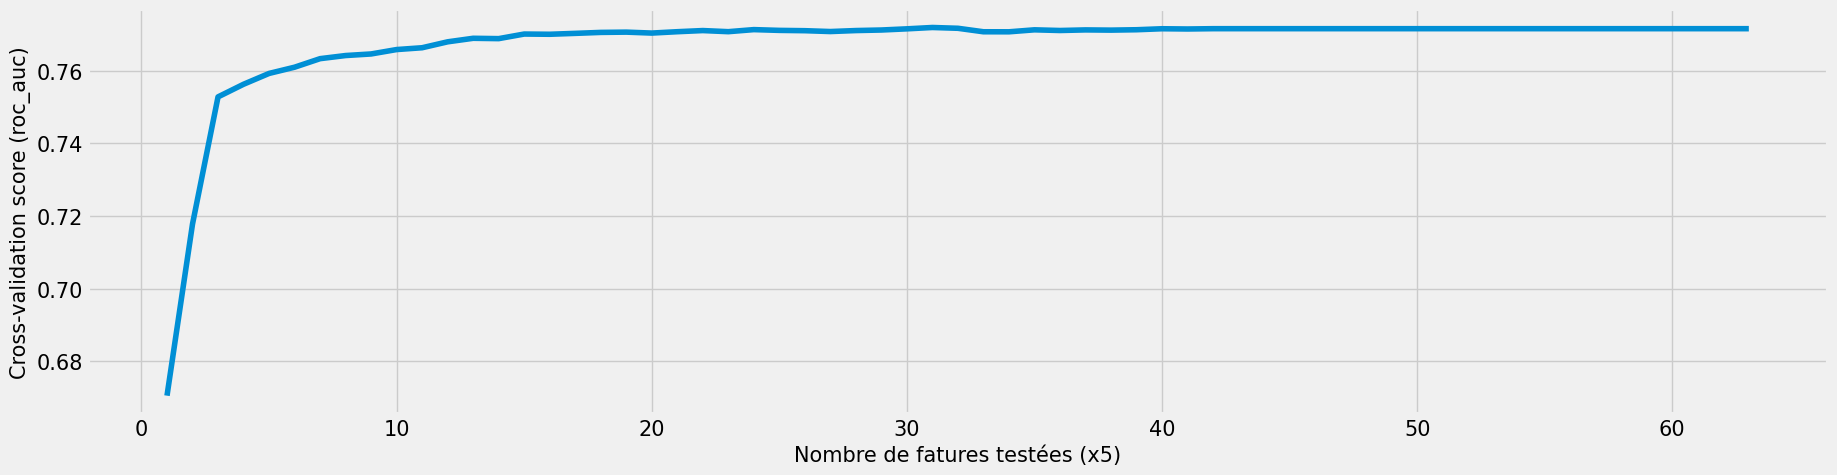

In [ ]:
step = 5
plt.figure(figsize=(20, 5))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.xlabel('Nombre de fatures testées (x%d)' % step)
plt.ylabel('Cross-validation score (roc_auc)')
plt.show()

### Sauvegarde de données réduites pour le Dashboard 

In [ ]:
#X_data is very important to implement the feature importance plot...
X_data = data_train.loc[:, data_train.columns[rfecv.get_support()]]
X_data.shape

(307507, 148)

In [ ]:
#Il est nécessaire de sauvegarder le dataset X_data  avec la target

#Merge operation with TARGET before save this reduced sample
X_data = X_data.merge(TARGET, left_index=True, right_index=True)
X_data.shape

(307507, 149)

In [ ]:
%%time
compression_opts = dict(method='zip', archive_name='X_data.csv')
X_data.to_csv('X_data.zip', index=True, compression=compression_opts)


CPU times: user 1min 28s, sys: 1.68 s, total: 1min 30s
Wall time: 1min 31s


In [ ]:
# copie d'un échantillon 
%%time
compression_opts = dict(method='zip', archive_name='X_sample.csv')
X_data.sample(30000).to_csv('X_sample.zip', index=True, compression=compression_opts)


CPU times: user 7.83 s, sys: 753 ms, total: 8.59 s
Wall time: 8.63 s


In [ ]:
%%time
X_data.sample(8000).to_csv('X_sample_8000.csv', index=True)
#échantillon de données train si besoin 

CPU times: user 1.35 s, sys: 30.8 ms, total: 1.38 s
Wall time: 1.39 s


In [ ]:
# réduction des données test 
z = ZipFile("/content/gdrive/My Drive/derniercsv/data_test.zip")
data_test= pd.read_csv(z.open('data_test.csv'), index_col='SK_ID_CURR', encoding ='utf-8')

X_data_test = data_test.loc[:, data_test.columns[rfecv.get_support()]]

compression_opts = dict(method='zip', archive_name='X_sample_test.csv')
X_data_test.sample(30000).to_csv('X_sample_test.zip', index=True, compression=compression_opts)
X_data_test.sample(8000).to_csv('X_sample_test_8000.csv', index=True)
#échantillon de données test si besoin 


###Bilan


---


La méthode RFECV a déjà été appliquée à l'ensemble d'entraînement (rfecv.fit(X_train, y_train)) pour identifier l'ensemble optimal de caractéristiques qui maximisera les performances du modèle en termes de métrique AUC.


### Reduction des features dans le jeu de données
Maintenant, pour appliquer cette sélection de caractéristiques optimales aux ensembles de données, nous utilisons la méthode transform(). Les données d'entraînement sont transformées en utilisant X_train_selected = rfecv.transform(X_train), tandis que les données de test sont transformées en utilisant X_test_selected = rfecv.transform(X_test).

Cela signifie que seules les caractéristiques sélectionnées par RFECV sont conservées dans les ensembles de données transformés (X_train_selected et X_test_selected). Les caractéristiques non sélectionnées, considérées comme moins importantes pour la prédiction, sont éliminées.


In [ ]:
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)


##Sélection du meilleur modèle sur les données réequilibrées après Feature selection

In [ ]:
#j'applique undersampling au jeu de données réduit
us = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_train_selected_us, y_train_selected_us = us.fit_resample(X_train_selected, y_train)

In [ ]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_selected_us, X_test_selected, y_train_selected_us, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
models_rfe = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
models_rfe.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_rfe.sort_values('AUC', ascending=False, inplace=True)


Learning rate set to 0.046882
0:	learn: 0.6862084	total: 53.2ms	remaining: 53.1s
1:	learn: 0.6801411	total: 99.2ms	remaining: 49.5s
2:	learn: 0.6745559	total: 145ms	remaining: 48.1s
3:	learn: 0.6691361	total: 236ms	remaining: 58.8s
4:	learn: 0.6647707	total: 324ms	remaining: 1m 4s
5:	learn: 0.6605177	total: 417ms	remaining: 1m 9s
6:	learn: 0.6565965	total: 522ms	remaining: 1m 14s
7:	learn: 0.6529560	total: 624ms	remaining: 1m 17s
8:	learn: 0.6496304	total: 733ms	remaining: 1m 20s
9:	learn: 0.6465292	total: 827ms	remaining: 1m 21s
10:	learn: 0.6437035	total: 922ms	remaining: 1m 22s
11:	learn: 0.6408416	total: 1.02s	remaining: 1m 23s
12:	learn: 0.6384148	total: 1.11s	remaining: 1m 24s
13:	learn: 0.6361755	total: 1.21s	remaining: 1m 24s
14:	learn: 0.6339684	total: 1.31s	remaining: 1m 26s
15:	learn: 0.6319546	total: 1.41s	remaining: 1m 26s
16:	learn: 0.6300274	total: 1.52s	remaining: 1m 27s
17:	learn: 0.6283941	total: 1.62s	remaining: 1m 28s
18:	learn: 0.6266886	total: 1.71s	remaining: 1m 

In [ ]:
#Models performance with features selection
models_rfe.style.hide_index()


Model,AUC,Accuracy,Precision,Recall,F1,Time
CatBoostClassifier,0.773648,0.708877,0.174780,0.701021,0.279799,60.096658
LGBMClassifier,0.768344,0.700411,0.170474,0.701962,0.274327,8.175557
RandomForestClassifier,0.746414,0.696422,0.163811,0.673206,0.263504,50.707709
DummyClassifier,0.500000,0.919331,0.000000,0.000000,0.000000,0.279230


### Bilan


---
Le modèle LGBM reste le plus performant en termes de score AUC/temps. Par conséquent, la prochaine étape consistera à trouver les meilleurs hyperparamètres en utilisant notre jeu de données rééquilibré et réduit.








## Hyperparameters tunning - Hyperopt et AUC score

Lorsqu'il s'agit de trouver les meilleurs hyperparamètres pour un modèle d'apprentissage automatique, il existe plusieurs méthodes de recherche, telles que la recherche aléatoire (Random Search), la recherche par grille (Grid Search) et l'optimisation Bayésienne, dont Hyperopt est un exemple. Voici quelques raisons pour lesquelles j'ai décidé de choisir Hyperopt par rapport à Random Search et Grid Search :

- **Efficacité de l'exploration de l'espace des hyperparamètres** : Hyperopt  est capable d'explorer l'espace des hyperparamètres de manière plus efficace que la recherche aléatoire ou la recherche par grille. Il utilise les informations recueillies lors des évaluations précédentes pour guider la sélection des hyperparamètres suivants, ce qui permet de converger plus rapidement vers de meilleurs résultats.

- **Utilisation des résultats précédents** : Hyperopt utilise une approche adaptative pour apprendre à partir des évaluations précédentes et ajuster la distribution de recherche des hyperparamètres. 


- **Adaptabilité aux différentes métriques d'évaluation** : Hyperopt permet de spécifier et d'optimiser différentes métriques d'évaluation, telles que l'exactitude (accuracy), le rappel (recall), la précision (precision) ou toute autre métrique pertinente pour votre problème spécifique. Il est capable de gérer des métriques d'évaluation personnalisées.

NB : La recherche des meuilleurs hyperparamètres peut être effectué par MLFLOW , ce dernier permet de suivre et gérer les expériences , le prochain notebook sera dédié à la recherche d'hyperparamètres via MLFLOW

In [ ]:
#Parameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
    }


# La fonction coût 

Cette fonction est une métrique personnalisée utilisée pour évaluer la performance d'un modèle de prêt bancaire. L'objectif de cette métrique est de minimiser le risque d'accord de prêt en pénalisant les faux négatifs (les cas où le modèle prédit à tort qu'un prêt est accordé alors qu'il aurait dû être refusé).

Voici comment la fonction est définie :

Elle prend en entrée deux arguments :

- **y_true** : la liste des valeurs réelles des étiquettes de classe (0 pour un prêt accordé, 1 pour un prêt refusé).
- **y_pred** : la liste  des valeurs prédites des étiquettes de classe par le modèle.

La fonction commence par calculer la matrice de confusion en utilisant la fonction confusion_matrix . Ensuite, la fonction extrait les éléments de la matrice de confusion pour obtenir les valeurs suivantes :

- **vn** : le nombre de vrais négatifs (cas où le modèle a correctement prédit un prêt accordé).
- **fn** : le nombre de faux négatifs (mauvais client prédit bon client).  
- **fp** : le nombre de faux positifs (bon client prédit mauvais
 client).
- **vp** : le nombre de vrais positifs (cas où le modèle a correctement prédit un prêt non accordé).

Ensuite, la fonction calcule un gain total (Gain) en utilisant des valeurs prédéfinies pour chaque type de prédiction (vrai positif, vrai négatif, faux positif, faux négatif). Le gain total est calculé en multipliant chaque nombre de prédictions par son coefficient correspondant et en les additionnant.


Enfin, la fonction normalise le gain total entre 0 et 1 en utilisant les valeurs du gain maximum et du gain minimum . Cela permet d'obtenir une valeur normalisée qui peut être comparée et interprétée de manière plus significative.

La fonction retourne la valeur normalisée (Gain_normalized) comme résultat de la métrique d'évaluation.



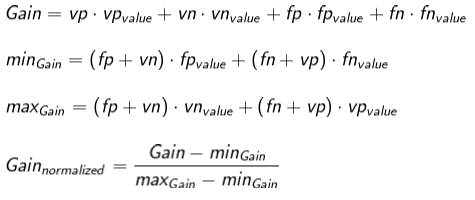


In [ ]:
def objective(params, eval_metric='custom_metric'):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params = {
        'n_estimators': int(params['n_estimators']), #le nombre d'estimateurs (arbres) dans l'algorithme
        'learning_rate': params['learning_rate'],#le taux d'apprentissage de l'algorithme
        'max_depth': int(params['max_depth']),#a profondeur maximale des arbres
        'subsample': params['subsample'],#a fraction d'échantillons utilisés pour ajuster chaque arbre
        'colsample_bytree': params['colsample_bytree'],#la fraction de colonnes (caractéristiques) utilisées pour ajuster chaque arbre
        'reg_lambda': params['reg_lambda'],# le terme de régularisation (lambda) pour contrôler la pénalisation des coefficients des arbres
        #'device':'gpu'
        }
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, X_train_selected_us, y_train_selected_us, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_metric': 
        y_pred = cross_val_predict(model, X_train_selected_us, y_train_selected_us, method='predict', cv=cv)
        score = custom_metric(y_train_selected_us, y_pred)
  
    loss = 1-score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}
#cross_val_predict renvoie les prédictions pour chaque échantillon de données lors de la validation croisée, tandis que cross_val_score renvoie les scores de performance moyens pour évaluer la performance du modèle lors de la validation croisée.

In [ ]:
# Utiliser Hyperopt pour optimiser les hyperparamètres
from hyperopt import fmin, tpe, hp
best_with_score_metier = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30, rstate=np.random.default_rng(42))

100%|██████████| 30/30 [23:51<00:00, 47.73s/trial, best loss: 0.2957487200138065]


In [ ]:
%%time
lgbm = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best_with_score_metier['n_estimators']), 
    colsample_bytree= best_with_score_metier['colsample_bytree'],
    learning_rate= best_with_score_metier['learning_rate'],
    max_depth= int(best_with_score_metier['max_depth']),
    subsample= best_with_score_metier['subsample'],
    reg_lambda= best_with_score_metier['reg_lambda'])

lgbm.fit(X_train_selected_us, y_train_selected_us)
# Sauvegarde du modèle pour une utilusaton ultéerieure 
pickle.dump(lgbm, open("/content/gdrive/My Drive/derniercsv/LGBMClassifier_derniercsv_us.pkl", "wb"))


CPU times: user 22.9 s, sys: 93.2 ms, total: 23 s
Wall time: 13.7 s


In [ ]:
lgbm

LGBMClassifier(colsample_bytree=0.6079716601949455,
               learning_rate=0.02414523467978224, max_depth=7, n_estimators=500,
               reg_lambda=11.503978934264442, subsample=0.7467843433308791)

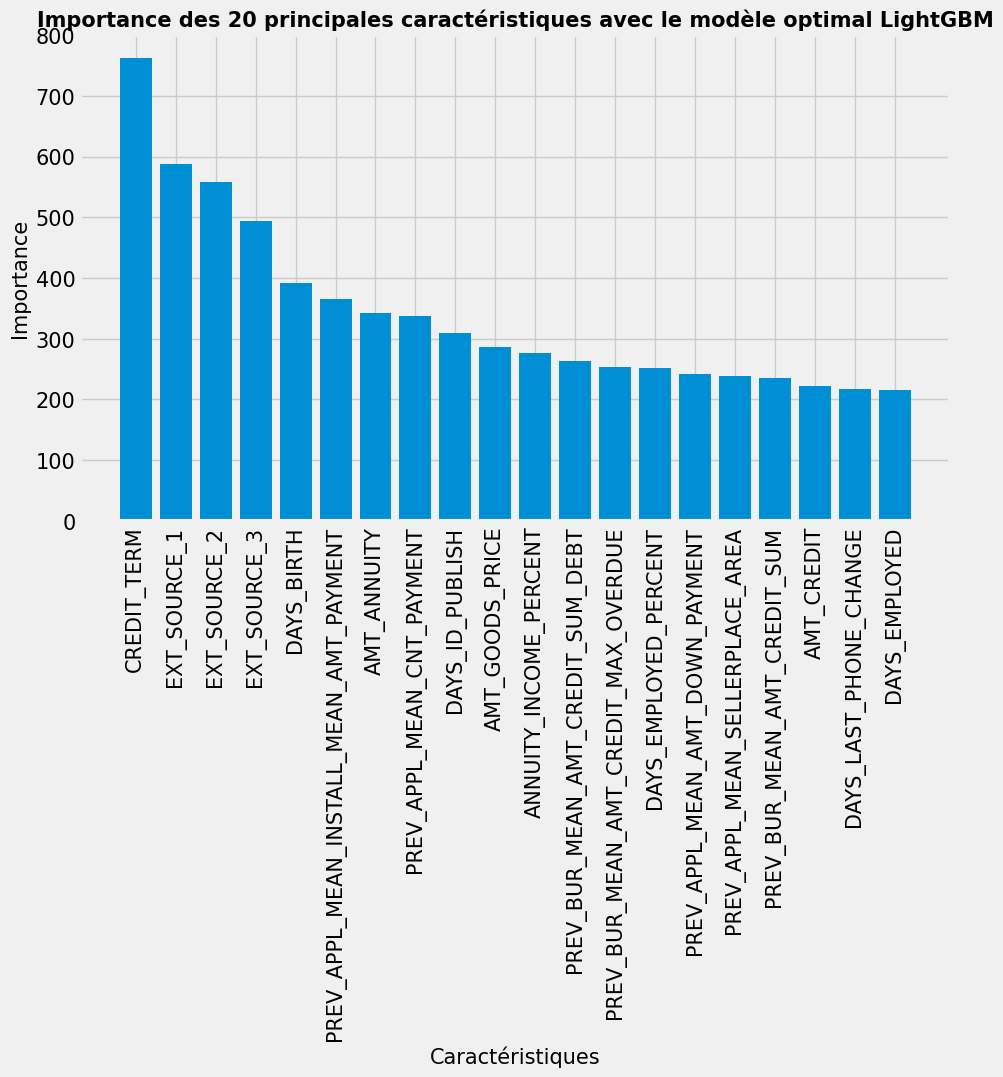

In [ ]:
# Obtenez l'importance des caractéristiques
feature_importance = lgbm.feature_importances_

# Sort feature importance in descending order and select top 20 features
top_features_indices = np.argsort(feature_importance)[::-1][:20]
top_feature_importance = feature_importance[top_features_indices]

# Get the corresponding feature names
top_feature_names = X_data.columns[top_features_indices]

# Create a bar plot to display feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_feature_importance)), top_feature_importance, align='center')
plt.xticks(range(len(top_feature_importance)), top_feature_names, rotation='vertical')
plt.xlabel('Caractéristiques')
plt.ylabel('Importance')
plt.title('Importance des 20 principales caractéristiques avec le modèle optimal LightGBM')
plt.tight_layout()
plt.show()


In [ ]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)


AUC : 0.772834


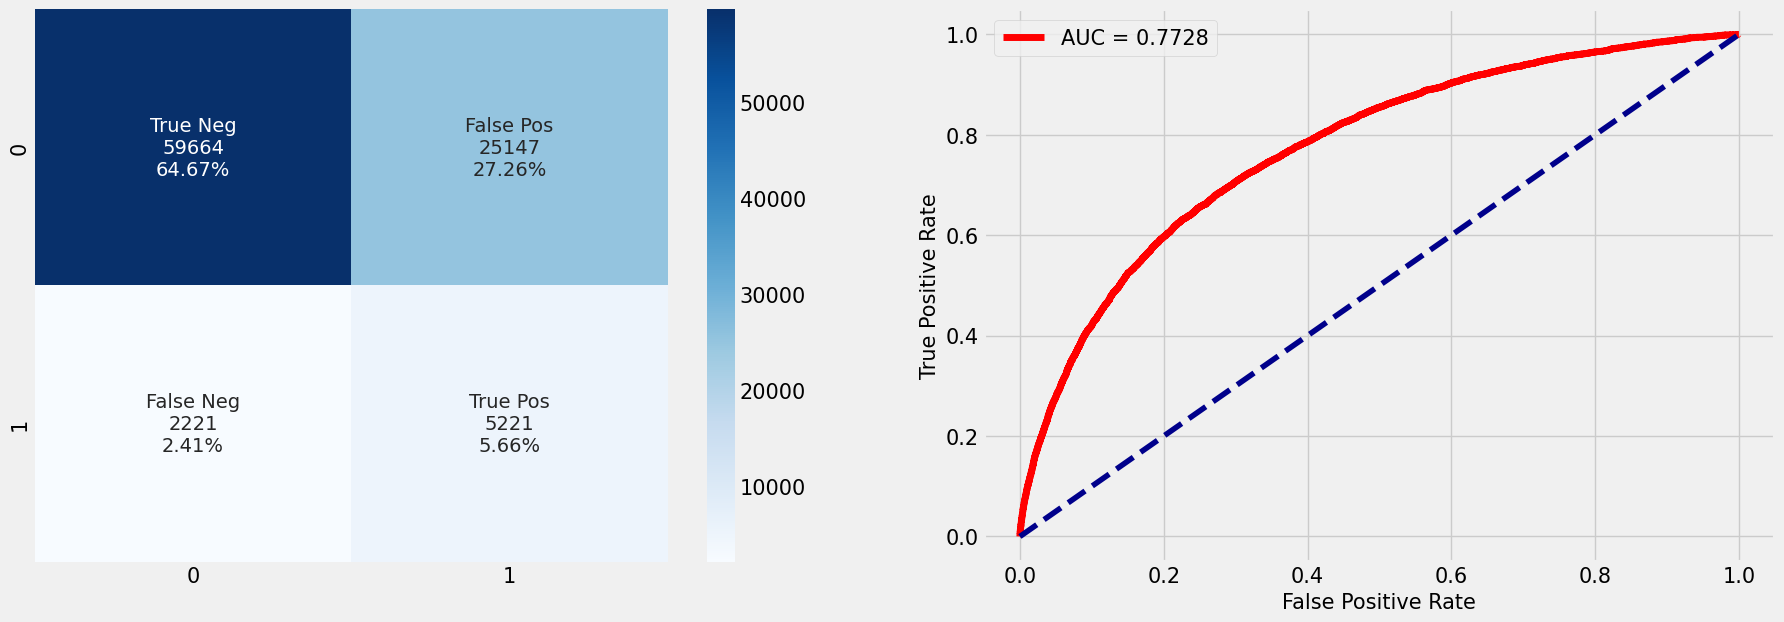

In [ ]:
cf_matrix_roc_auc(lgbm, y_test, lgbm.predict(X_test_selected), lgbm.predict_proba(X_test_selected)[:,1], feature_importances=False)


In [ ]:
#seuil pourlequel on doit décider si pret accordé ou pas 
#on calcule le score métier et les prédiction


# j'ai testé plusieurs coeff 
def custom_metric(y_true, y_pred, fn_value=-100, fp_value=-10, vp_value=0, vn_value=1):

    #Matrice de Confusion
    mat_conf = confusion_matrix(y_true, y_pred)
    # Nombre de vrai Négatifs
    vn = mat_conf[0, 0]
    # Nombre de Faux Négatifs
    fn = mat_conf[1, 0]
    # Nombre de Faux Positifs
    fp = mat_conf[0, 1]
    # Nombre de vrai Positifs
    vp = mat_conf[1, 1]
    
    # Gain total
    Gain = vp*vp_value + vn*vn_value + fp*fp_value + fn*fn_value
    
    # Gain maximum
    max_Gain = (fp + vn)*vn_value + (fn + vp)*vp_value
    
    # Gain minimum
    min_Gain = (fp + vn)*fp_value + (fn + vp)*fn_value
    
    # Gain normalisé entre 0 et 1
    Gain_normalized = (Gain - min_Gain)/(max_Gain - min_Gain)
    
    return Gain_normalized  # Retourne la fonction d'évaluation


In [ ]:
def gain_seuil(clf, x_set, y_set):
    """
    Evolution du gain en fonction du seuil de solvabilité fixé
    Si score < seuil : client solvable
    Sinon : client non solvable
    """
    cost_function = []
    threshold_x = np.linspace(0.0, 1, 30)

    for threshold in threshold_x:
        # Score du modèle : 0 à 1
        y_scores = clf.predict_proba(x_set)[:, 1]

        # Score > seuil de solvabilité : retourne 1 sinon 0
        y_pred = (y_scores > threshold)

        y_pred = np.array(y_pred > 0) * 1
        # Calcul de l'indice bancaire
        cost_function.append(custom_metric(y_set, y_pred))

    # Trouver l'indice de la fonction maximale
    max_index = np.argmax(cost_function)
    max_threshold = threshold_x[max_index]
    max_cost = cost_function[max_index]

    # Affichage de l'indice bancaire maximal et seuil de probabilité correspondant
    print("Indice banquaire maximal:", np.round(max_cost, 2))
    print("Seuil de probabilité correspondant:", np.round(max_threshold, 2))
    
    # Affichage du gain en fonction du seuil de solvabilité
    plt.plot(threshold_x, cost_function)
    plt.axvline(x=max_threshold, color='r', linestyle='--', label='Seuil optimal')  # Tracer une ligne verticale
    plt.xlabel("Seuil de probabilité")
    plt.ylabel("Indice banquaire")
    plt.xticks(np.linspace(0.0, 1, 11))
    plt.legend()
    plt.show()


In [ ]:
def cost_false(model, y_true, X_true):
    '''Cost function analyzes prediction errors False Pos. and False Neg.'''
    cm = confusion_matrix(y_true, model.predict(X_true))
    FP = cm[0][1]/np.sum(cm)
    FN = cm[1][0]/np.sum(cm)
  
    print("False Pos: {0:.2%}".format(FP))
    print("False Neg: {0:.2%}".format(FN))
    return FP, FN


In [ ]:
#FP and FN
cost_false(lgbm, y_test, X_test_selected)


False Pos: 27.26%
False Neg: 2.41%


(0.27258734133307316, 0.024075097828796896)

In [ ]:
#Check list features importance 
sorted_idx = np.argsort(lgbm.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_data.columns[index], lgbm.feature_importances_[index]]) 


['CREDIT_TERM', 762]
['EXT_SOURCE_1', 588]
['EXT_SOURCE_2', 558]
['EXT_SOURCE_3', 494]
['DAYS_BIRTH', 391]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT', 365]
['AMT_ANNUITY', 343]
['PREV_APPL_MEAN_CNT_PAYMENT', 338]
['DAYS_ID_PUBLISH', 309]
['AMT_GOODS_PRICE', 286]
['ANNUITY_INCOME_PERCENT', 277]
['PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT', 264]
['PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE', 253]
['DAYS_EMPLOYED_PERCENT', 251]
['PREV_APPL_MEAN_AMT_DOWN_PAYMENT', 242]
['PREV_APPL_MEAN_SELLERPLACE_AREA', 239]
['PREV_BUR_MEAN_AMT_CREDIT_SUM', 235]
['AMT_CREDIT', 222]
['DAYS_LAST_PHONE_CHANGE', 217]
['DAYS_EMPLOYED', 215]
['PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE', 212]
['DAYS_REGISTRATION', 206]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_NUMBER', 198]
['PREV_BUR_MEAN_DAYS_CREDIT', 188]
['CREDIT_INCOME_PERCENT', 174]
['PREV_APPL_MEAN_AMT_ANNUITY', 173]
['CODE_GENDER', 170]
['PREV_APPL_MEAN_DAYS_DECISION', 167]
['PREV_BUR_MEAN_DAYS_ENDDATE_FACT', 166]
['PREV_APPL_MEAN_DAYS_TERMINATION', 157]
['PREV_APPL_MEAN_D

### Seuil de probabilité :
Le score métier gain doit être maximisé pour que la banque gagne le plus d'argent et ainsi permettre de déterminer à partir de quel seuil de probabilité un client est considéré comme solvable ou non. d'une manière générale ,  le seuil est de 0,5 mais au vu de la courbe du score gain (avec 
les coefficients personnalisés) ,  le seuil optimal est 0.59

Indice banquaire maximal: 0.71
Seuil de probabilité correspondant: 0.59


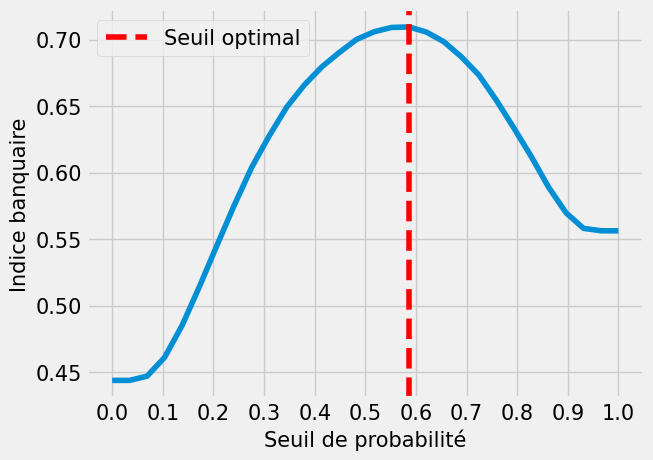

In [ ]:
gain_seuil(lgbm, X_test_selected, y_test)

## SHAP (SHapley Additive exPlanations) 
SHAP est une méthode d'explanaibilité qui fournit des valeurs d'importance individuelle pour chaque caractéristique d'entrée, permettant ainsi de mieux comprendre les prédictions d'un modèle d'apprentissage automatique.






In [ ]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(lgbm)


In [ ]:
pickle.dump(explainer, open("/content/gdrive/My Drive/derniercsv/explainer0706.pkl", "wb"))

In [ ]:
# Apply Shap on test set because it is what we want to explain
shap_values = explainer.shap_values(X_test_selected)

### Importance globale : 

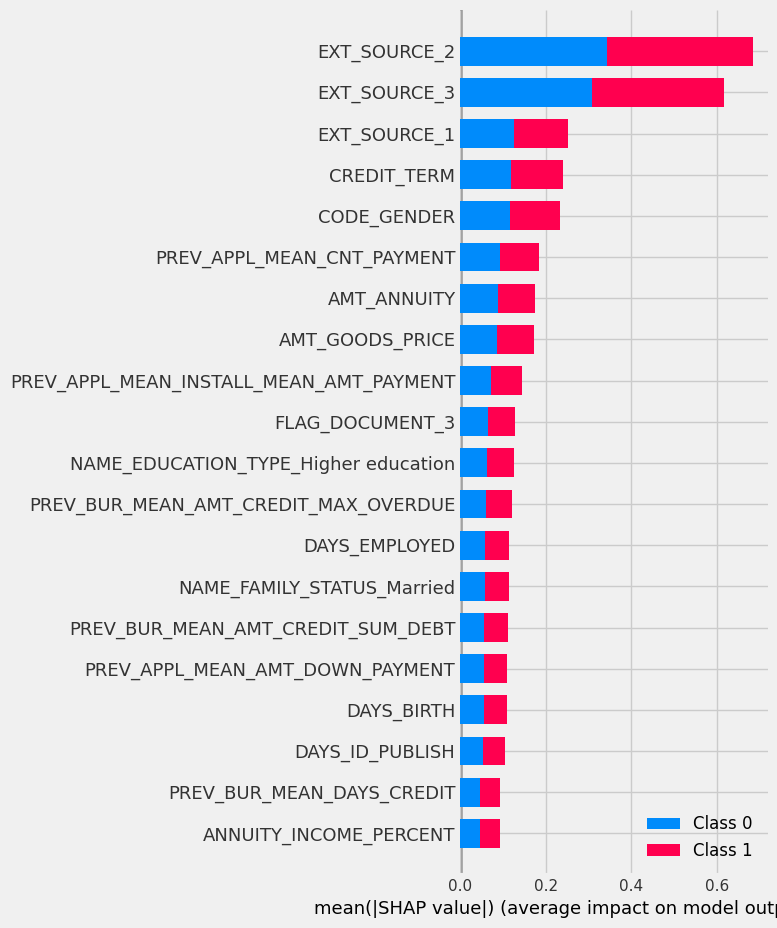

In [ ]:
# Variable Importance Plot — Global Interpretability
# Only plot_type = 'bar' is supported for multi-output explanations!

shap.summary_plot(shap_values, X_test_selected, plot_type="bar", feature_names=X_data_test.columns)


#### Bilan


---


Les valeurs SHAP peuvent être interprétées comme des mesures d'importance ou de contribution pour chaque caractéristique, où une valeur positive indique une contribution positive et une valeur négative indique une contribution négative. Ces valeurs aident à comprendre quels facteurs ont influencé une prédiction spécifique et à quel degré.
par exemple pour notre modèle Ext_source_3 , Ext_source_2 et Ext_source_1 sont les plus imporatantes pour la prise de décision. 


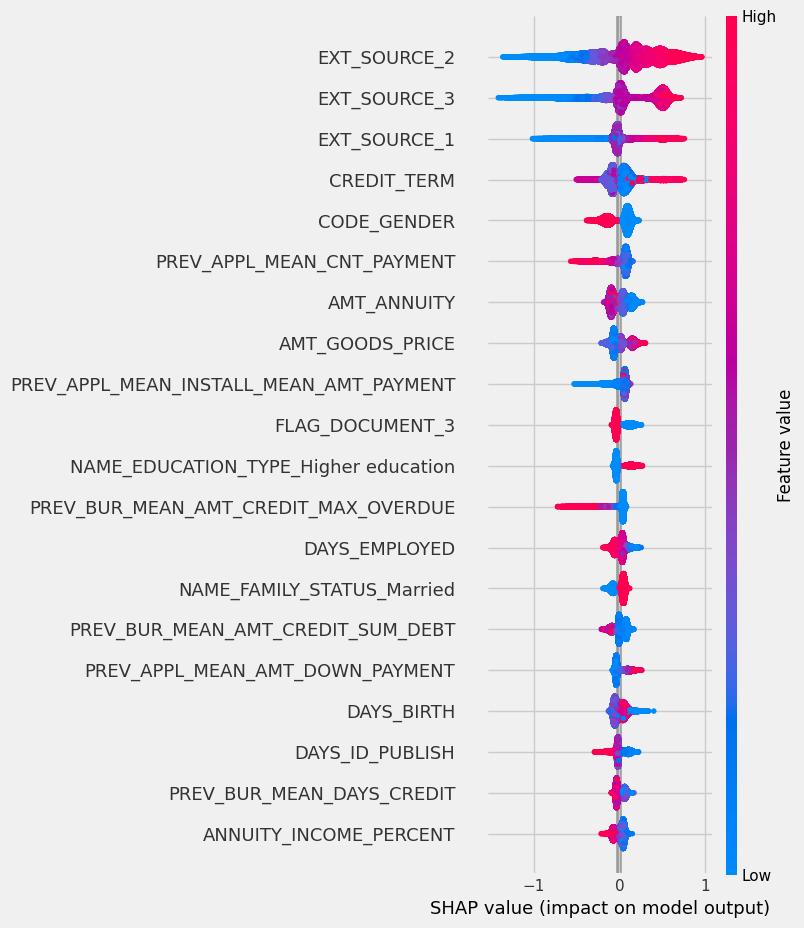

In [ ]:
shap.summary_plot(shap_values[0], X_test_selected, feature_names=X_data.columns)


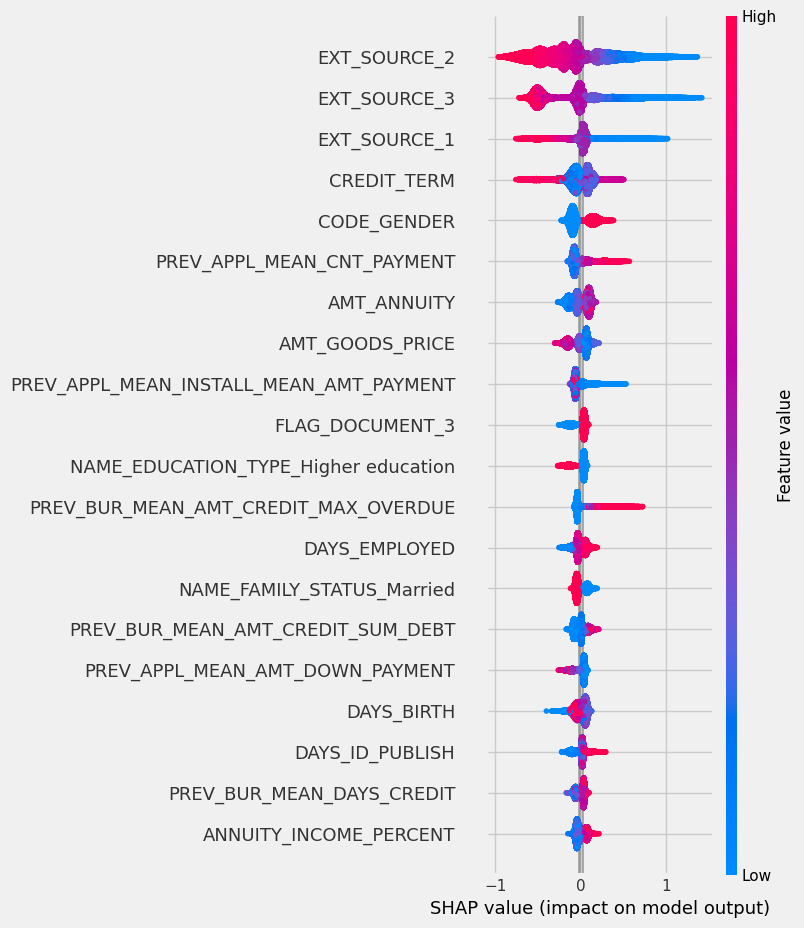

In [ ]:
shap.summary_plot(shap_values[1], X_test_selected, feature_names=X_data_test.columns)


### Importance locale : 

0.0003176061837607464


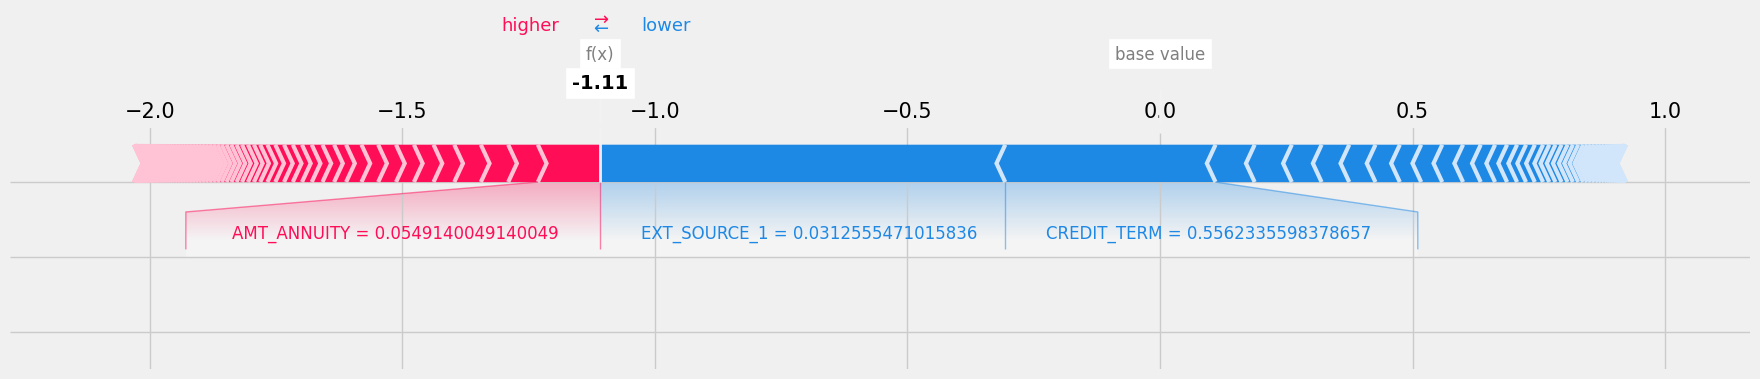

In [ ]:
# Individual SHAP Value Plot — Local Interpretability
# Visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
# Afficher le graphique de la valeur SHAP individuelle
# Afficher le graphique de la valeur SHAP individuelle
print(explainer.expected_value[0])
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test_selected[0,:], feature_names=X_data_test.columns, matplotlib=True)

# Afficher le graphique dans Colab
plt.show()


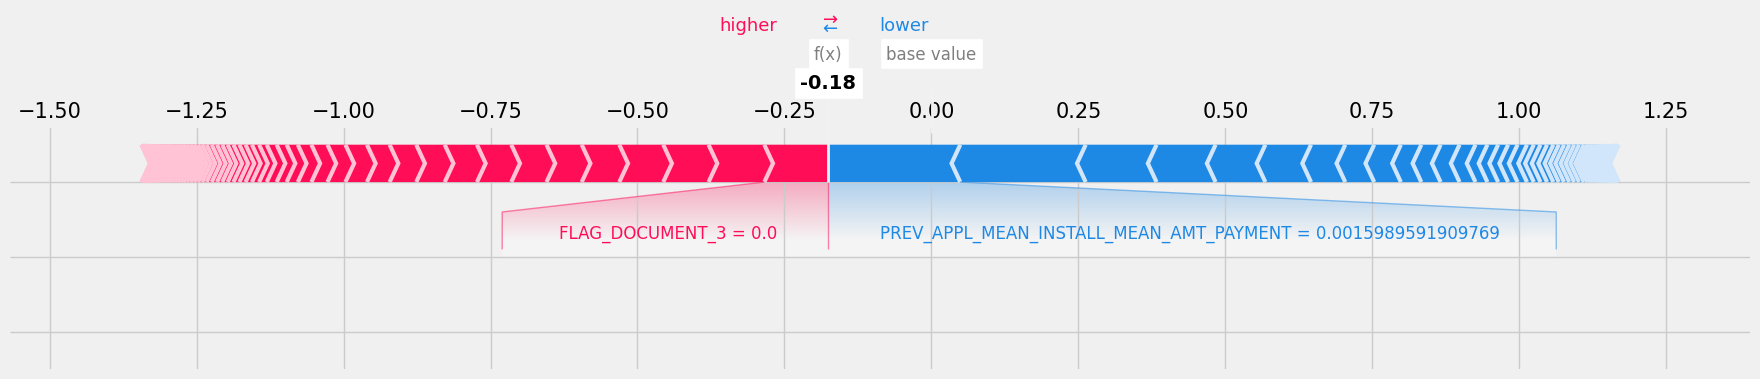

In [ ]:
# Afficher le graphique de la valeur SHAP individuelle pour index 5 
shap.force_plot(explainer.expected_value[0], shap_values[0][5, :], X_test_selected[5, :], feature_names=X_data_test.columns, matplotlib=True)

# Afficher le graphique dans Colab
plt.show()